Hypothesis testing is a statistical method used to determine if there is enough evidence in a sample of data to infer that a certain condition is true for an entire population.

General Procedure for Hypothesis Testing:
1. Formulate $H_0$ and $H_1$.
2. Select a significance level($\alpha$, typically 0.05).
3. Choose the appropriate statistical test(t-test, Mann-Whitney U, ANOVA, etc.) based on data type and hypothesis.
4. Calculate the test statistic and p-value using libraries like scipy.stats or statesmodels in python.
5. Make a decision (reject or fail to reject $H_0$) based on comparing the p-value to the significance level.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, f_oneway, levene

In [3]:
# 1. Load rolling windows sequence (NumPy array)
rolling_data = np.load('/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy')
# 2. Load sequence metadata with RUL target(engine_id, cycle, RUL)
metadata = pd.read_csv('/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv')

In [11]:
import numpy as np
import pandas as pd

# Assume rolling_data is a 3D NumPy array: (samples, timesteps, features)
n_samples, n_timesteps, n_features = rolling_data.shape
print(f"3D Array detected: {n_samples} samples, {n_timesteps} timesteps, {n_features} features")

# Compute basic statistics
means = rolling_data.mean(axis=1)
stds = rolling_data.std(axis=1)
mins = rolling_data.min(axis=1)
maxs = rolling_data.max(axis=1)
medians = np.median(rolling_data, axis=1)
ranges = np.ptp(rolling_data, axis=1)   # ptp = max - min

# Combine all computed features
combined_stats = np.hstack([means, stds, mins, maxs, medians, ranges])

# Create column names
stat_names = ['mean', 'std', 'min', 'max', 'median', 'range']
columns = [f'sensor_{i+1}_{stat}' for i in range(n_features) for stat in stat_names]

# Convert to DataFrame
rolling_stats_df = pd.DataFrame(combined_stats, columns=columns)
print(f"Rolling stats DataFrame created: {rolling_stats_df.shape}")

# Merge with metadata if available and same length
if 'metadata' in locals() and len(metadata) == len(rolling_stats_df):
    df = pd.concat([metadata.reset_index(drop=True), rolling_stats_df.reset_index(drop=True)], axis=1)
    print(f"✓ Combined with metadata: {df.shape}")
else:
    df = rolling_stats_df.copy()
    print("Using only statistical features (no metadata)")

# Display result
df.head()


3D Array detected: 152559 samples, 30 timesteps, 66 features
Rolling stats DataFrame created: (152559, 396)
✓ Combined with metadata: (152559, 399)


,engine_id,cycle,RUL,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_max,sensor_1_median,sensor_1_range,sensor_2_mean,...,sensor_65_min,sensor_65_max,sensor_65_median,sensor_65_range,sensor_66_mean,sensor_66_std,sensor_66_min,sensor_66_max,sensor_66_median,sensor_66_range
0,1,8.0,313.0,-0.109839,-0.153646,-0.085651,0.137113,0.097279,0.042308,0.052575,...,2.729256,3.63071,3.79367,3.364127,4.231473,2.341016,2.219011,2.918826,2.221991,2.955884
1,1,8.0,313.0,-0.095721,-0.153646,-0.085651,0.132248,0.092359,0.038232,0.046103,...,2.729256,3.63071,3.79367,3.364127,4.231473,2.341016,2.219011,2.485496,2.221991,2.513336
2,1,9.0,312.0,-0.095719,-0.153673,-0.085651,0.132248,0.092171,0.040418,0.045604,...,2.729256,3.63071,3.79367,3.364127,4.231473,2.341016,2.219011,2.485496,2.221991,2.513336
3,1,9.0,312.0,-0.095730,-0.153609,-0.085651,0.132248,0.091896,0.041772,0.049155,...,2.729256,3.63071,3.79367,3.364127,4.231473,2.341016,2.219011,2.485496,2.221991,2.513336
4,1,9.0,312.0,-0.095739,-0.153582,-0.085651,0.132248,0.091496,0.040641,0.049980,...,2.729256,3.63071,3.79367,3.364127,4.231473,2.341016,2.219011,2.485496,2.221991,2.519183


In [12]:
# Prepare Operational Phases


# Adjust these column names based on your data
unit_col = 'engine_id'
cycle_col = 'cycle'

# Calculate max cycles per unit
max_cycles = df.groupby(unit_col)[cycle_col].max().reset_index()
max_cycles.columns = [unit_col, 'max_cycle']

# Merge back
df = df.merge(max_cycles, on=unit_col)

# Calculate cycle percentage
df['cycle_percent'] = (df[cycle_col] / df['max_cycle']) * 100

# Assign phases
df['phase'] = pd.cut(df['cycle_percent'],
                     bins=[0, 30, 70, 100],
                     labels=['early', 'middle', 'late'])

print("Operational phases assigned")
print(f"\nPhase distribution:")
print(df['phase'].value_counts())

# Show sample
print(f"\nSample data with phases:")
print(df[[unit_col, cycle_col, 'cycle_percent', 'phase']].head(10))


Operational phases assigned

Phase distribution:
phase
middle    70664
early     51642
late      30253
Name: count, dtype: int64

Sample data with phases:
   engine_id  cycle  cycle_percent  phase
0          1    8.0       2.492212  early
1          1    8.0       2.492212  early
2          1    9.0       2.803738  early
3          1    9.0       2.803738  early
4          1    9.0       2.803738  early
5          1    9.0       2.803738  early
6          1   10.0       3.115265  early
7          1   10.0       3.115265  early
8          1   10.0       3.115265  early
9          1   10.0       3.115265  early


Feature: sensor_7_mean
t-statistic: 32.2757, p-value: 0.0000
Cohen’s d: 0.253
The average (mean) of sensor_7 is the same in early and late phases.(Reject H₀)


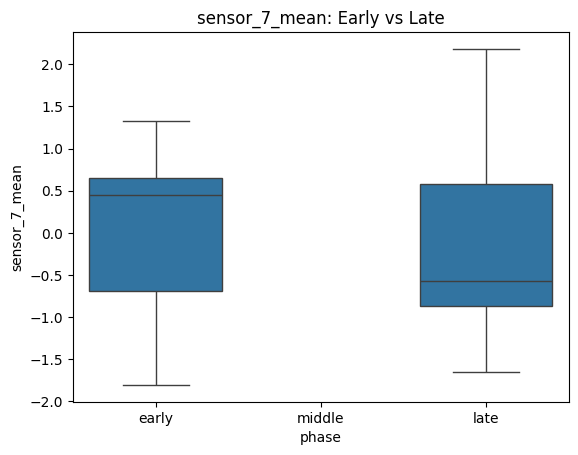

In [6]:
feature = 'sensor_7_mean'

alpha = 0.05

early = df[df['phase'] == 'early'][feature].dropna()
late = df[df['phase'] == 'late'][feature].dropna()

# Levene’s test for equal variance
_, p_levene = levene(early, late)
equal_var = p_levene >= alpha

# Two-sample t-test
t_stat, p_value = ttest_ind(early, late, equal_var=equal_var)

# Effect size
pooled_std = np.sqrt(((len(early)-1)*early.std()**2 + (len(late)-1)*late.std()**2) /
                     (len(early) + len(late) - 2))
cohen_d = (early.mean() - late.mean()) / pooled_std

print(f"Feature: {feature}")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
print(f"Cohen’s d: {cohen_d:.3f}")
if p_value < alpha:
    print("The average (mean) of sensor_7 is the same in early and late phases.(Reject H₀)")
else:
    print("The average (mean) of sensor_7 differs between early and late phases. (Fail to reject H₀)")

sns.boxplot(x='phase', y=feature, data=df[df['phase'].isin(['early','late'])])
plt.title(f'{feature}: Early vs Late')
plt.show()


Test 2: Standard Deviation Comparison
H₀:The standard deviation (variability) of sensor_7 readings is the same in both phases.
H₁:The variability differs between early and late phases.
t-statistic = 90.4542, p-value = 0.0000
Reject H₀


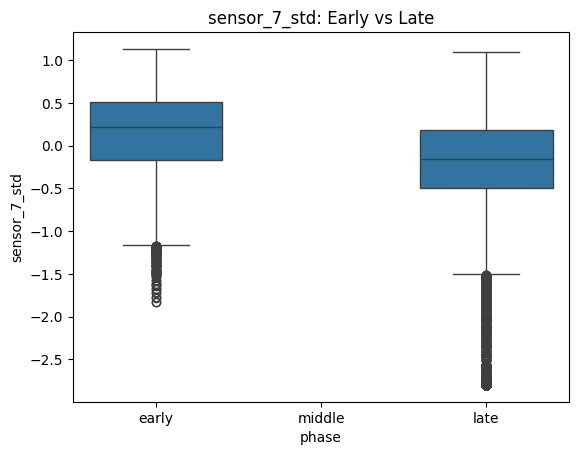

In [7]:
#Test 2: Standard Deviation (Variability) Difference

feature = 'sensor_7_std'

early = df[df['phase'] == 'early'][feature].dropna()
late = df[df['phase'] == 'late'][feature].dropna()

# t-test
t_stat, p_value = ttest_ind(early, late, equal_var=False)

print("Test 2: Standard Deviation Comparison")
print("H₀:The standard deviation (variability) of sensor_7 readings is the same in both phases.")
print("H₁:The variability differs between early and late phases.")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Reject H₀")
else:
    print("Fail to reject H₀")

sns.boxplot(x='phase', y=feature, data=df[df['phase'].isin(['early','late'])])
plt.title(f'{feature}: Early vs Late')
plt.show()


Test 3: Minimum Value Comparison
H₀:The minimum values of sensor_7 are the same in early and late phases.
H₁:The minimum values differ between the phases.
t-statistic = 32.6636, p-value = 0.0000
Reject H₀


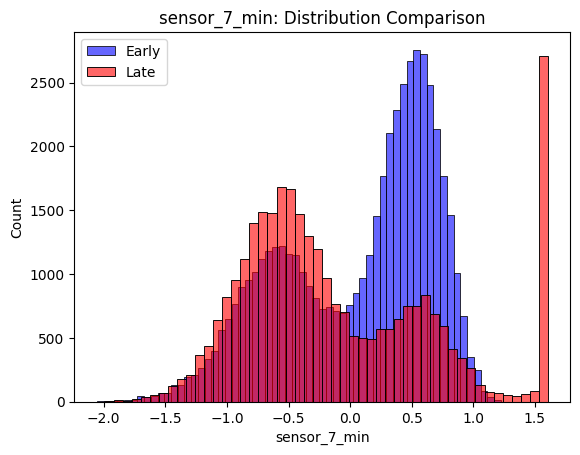

In [8]:
# Test 3: Minimum Value Difference
feature = 'sensor_7_min'

early = df[df['phase'] == 'early'][feature].dropna()
late = df[df['phase'] == 'late'][feature].dropna()

t_stat, p_value = ttest_ind(early, late, equal_var=False)

print("Test 3: Minimum Value Comparison")
print("H₀:The minimum values of sensor_7 are the same in early and late phases.")
print("H₁:The minimum values differ between the phases.")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Reject H₀")
else:
    print("Fail to reject H₀")

sns.histplot(early, color='blue', label='Early', alpha=0.6)
sns.histplot(late, color='red', label='Late', alpha=0.6)
plt.legend()
plt.title(f'{feature}: Distribution Comparison')
plt.show()


Test 4: Maximum Value Comparison
H₀: The maximum sensor readings are the same in early and late phases.
H₁: The maximum sensor readings differ.
t-statistic = 27.0330, p-value = 0.0000
Reject H₀


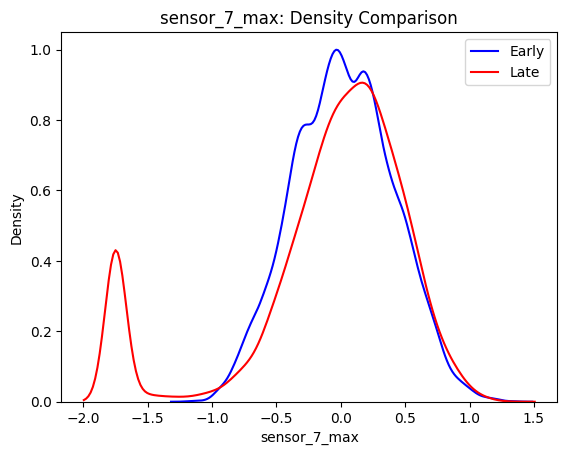

In [9]:
# Test 4: Maximum Value Difference
feature = 'sensor_7_max'

early = df[df['phase'] == 'early'][feature].dropna()
late = df[df['phase'] == 'late'][feature].dropna()

t_stat, p_value = ttest_ind(early, late, equal_var=False)

print("Test 4: Maximum Value Comparison")
print("H₀: The maximum sensor readings are the same in early and late phases.")
print("H₁: The maximum sensor readings differ.")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Reject H₀")
else:
    print("Fail to reject H₀")

sns.kdeplot(early, color='blue', label='Early')
sns.kdeplot(late, color='red', label='Late')
plt.legend()
plt.title(f'{feature}: Density Comparison')
plt.show()


Test 5: Range Comparison (Mann–Whitney U)
H₀: The range (max–min) of sensor_7 is the same across early and late phases.
H₁: The range differs between early and late phases.
U-statistic = 972976169.0000, p-value = 0.0000
Reject H₀


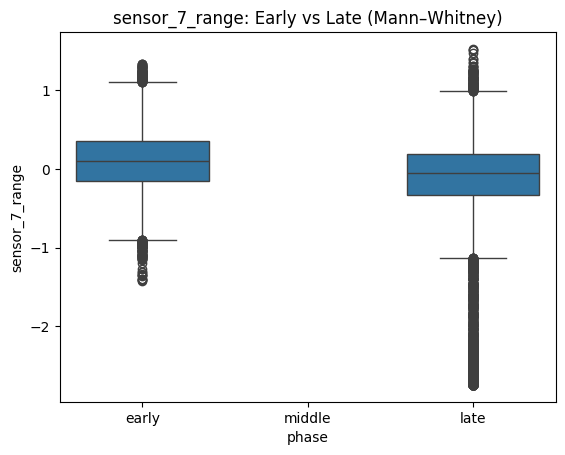

In [10]:
# Test 5: Range Difference (Non-parametric
feature = 'sensor_7_range'

early = df[df['phase'] == 'early'][feature].dropna()
late = df[df['phase'] == 'late'][feature].dropna()

# Non-parametric Mann–Whitney U test
u_stat, p_value = mannwhitneyu(early, late, alternative='two-sided')

print("Test 5: Range Comparison (Mann–Whitney U)")
print("H₀: The range (max–min) of sensor_7 is the same across early and late phases.")
print("H₁: The range differs between early and late phases.")
print(f"U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Reject H₀")
else:
    print("Fail to reject H₀")

sns.boxplot(x='phase', y=feature, data=df[df['phase'].isin(['early','late'])])
plt.title(f'{feature}: Early vs Late (Mann–Whitney)')
plt.show()
